In [1]:
# models output : [buy, hold, sell]

In [2]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from keras import models, layers, optimizers
from keras.losses import huber_loss
from keras.regularizers import L1L2

from collections import deque

import gc


Using TensorFlow backend.


In [3]:
def make_models(input_size, output_size=1, n_layers=2):
    inputs = layers.Input(shape=(input_size, ))
    x = layers.Dense(16, activation='relu', kernel_regularizer = L1L2(l2= 0.001))(inputs)

    for i in range(n_layers-1):
        x = layers.Dense(16//(2**(i+1)), kernel_regularizer=L1L2(l2= 0.001))(x)
#         x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

    outputs = layers.Dense(output_size, activation='linear')(x)

    model = models.Model(inputs, outputs)

    model.compile(optimizer = 'adam',
                 loss = huber_loss)

    return model

In [4]:
class Memory:
    def __init__(self):
        self.buffer = deque(maxlen=memory_size)
        
    def add(self, exp):
        self.buffer.append(exp)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    def reset(self):
        self.buffer = deque(maxlen=memory_size)
        
    def __len__(self):
        return len(self.buffer)
    
    

In [5]:
data = pd.read_csv('./data/stock.csv', thousands=',')
d = data.drop(['date', 'close', 'high', 'low'], axis=1)
d.columns

moving = pd.Series()
for cat in d.columns:
    for i in (5, 10, 30, 60):
        moving = pd.concat([moving, d[cat].rolling(i).mean()], axis=1)
        
moving.columns = ['0', 'moving_p5','moving_p10','moving_p30','moving_p60',
                  'moving_vol5','moving_vol10','moving_vol30','moving_vol60',
                  'moving_per5','moving_per10','moving_per30','moving_per60',
                  'moving_pbr5','moving_pbr10','moving_pbr30','moving_pbr60']

moving = moving.drop('0', axis=1)
moving = pd.concat([moving, data.high, data.low], axis=1)

X = moving[61:]
y = data.open[61:]

X = (X - np.min(X))/(np.max(X) - np.min(X))
# y = (y - np.min(y))/(np.max(y) - np.min(y))

state = X.values.copy()
p = y.values.copy()
# p += 1e-5

In [13]:
# not reward clipped version
class Agent:
    def __init__(self, balance, state):
        self.fs = [balance, 30] # [cash, n_stock]
        self.balance = self.update_balance(self.fs, p[0])
        self.state = state
        self.main = make_models(18)
        self.learner = make_models(18)
        
        
    def train(self, n_steps):
        success_count = 0
        for n in range(n_steps):
#             if success_count >= 5:
#                 break
            BALANCE = self.balance
            fs = self.fs.copy()
            balance = self.balance
            step = 0
            steps = len(self.state)
            for i in range(0, steps-2):
                step += 1
                eps = 0.01 + (EPS - 0.01) * np.exp(-DECAY * step)

                self.learner.set_weights(self.main.get_weights())
                
                # current stock price
                price = p[i]
                
                # action 
                if eps > np.random.rand():
                    action = np.random.uniform(-fs[1], fs[0]/price)
                else:
                    action = self.main.predict(state[i:i+1])[0][0]

                # update fs
                fs = self.update_fs(fs, action, price)
                
                # update balance and make reward
                new_balance = self.update_balance(fs, price)

                reward = ((new_balance / balance) - 1) * 100
#                 reward = abs(action) if reward>0 else 0
#                 print(reward)

                balance = new_balance

                # memorize
                if step > WARMUP:
                    memory.add((state[i:i+1], action, reward, state[i+1:i+2]))

                # learner update
            for _ in range(10):

                np.random.seed(_)
                inputs = np.zeros((BATCH_SIZE, 18))
                targets = np.zeros((BATCH_SIZE, 1))

                minibatch = memory.sample(BATCH_SIZE)

                for j, (s, a, r, ss) in enumerate(minibatch):
                    inputs[j] = s
                    if not (ss == np.zeros(s.shape)).all(axis=1):
                        target = r + GAMMA * self.learner.predict(ss)[0][0]
                    else:
                        target = r
                        
                    targets[j] = target
                
#                     targets[j][a] = target

                self.main.fit(inputs, targets, epochs=1, verbose=0)


            # as episode end
                hist = self.simulation()
                hist = np.array(hist) - self.balance
                plt.axhline(y=0, color='r', linestyle='-')
                plt.plot(hist)
                plt.show()
                print((_+1), 'steps','mean gain:', round(np.mean(hist)/BALANCE, 3))
#                 if np.mean(hist)/BALANCE == 0:
#                     self.main = make_models(18)
                    
#                 if hist[-1] / BALANCE > 1:
#                     success_count += 1
#                 else:
#                     success_count = 0
                    
#                 if success_count >= 5:
#                     break
                    
            
        return fs, balance
            
    def update_fs(self, fs, action, price):
        if action >= 0:
            n = min(fs[0]/price, action)
            fs[1] += n
            fs[0] += -n*price
        else:
            n = min(abs(action), fs[1])
            fs[1] -= n
            fs[0] += n*price
        

        return fs
            
        
    
    def update_balance(self, fs, price):
        b = fs[0] + fs[1] * price
        return b
        
    def simulation(self, debug=False):
        fs = self.fs.copy()
        balance = self.balance
        hist = []
        sales = [0, 0]
        print(balance)
        for i in range(len(state)-1):
            a = self.main.predict(self.state[i:i+1])[0][0]
            price = p[i]
            fs = self.update_fs(fs, a, price)
            balance = self.update_balance(fs, price)
            hist.append(balance)
            if a>0: sales[0] += 1 
            else: sales[1] += 1
            if debug:
                print(sales, balance)
        print(sales)
        return hist


In [7]:
GAMMA = 0.99
WARMUP = 20
N_EPISODES = 2
EPS = 0.1
DECAY = 0.01

memory_size = 1000
BATCH_SIZE = 512
TRAIN_STEP = 200

BALANCE = 10000000

memory = Memory()
a = Agent(BALANCE, state)
gc.collect()

0

[2017, 1222]


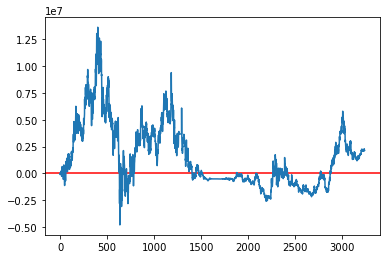

1 steps mean gain: 0.082
[2476, 763]


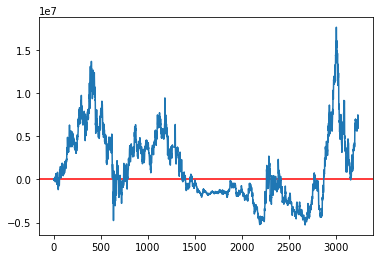

2 steps mean gain: 0.076
[2591, 648]


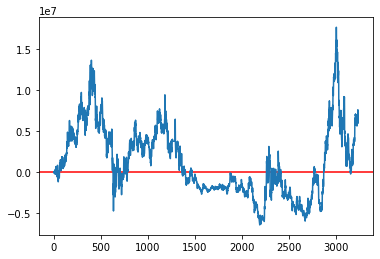

3 steps mean gain: 0.066
[2430, 809]


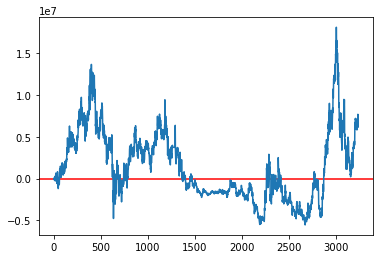

4 steps mean gain: 0.075
[2376, 863]


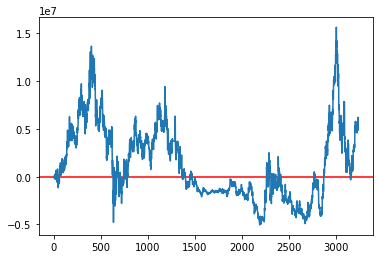

5 steps mean gain: 0.07
[2320, 919]


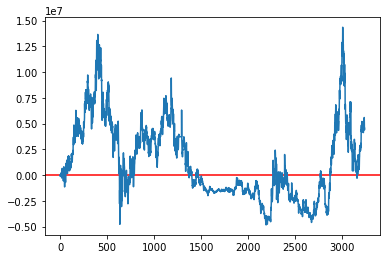

6 steps mean gain: 0.07
[2359, 880]


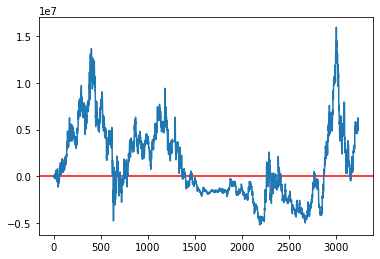

7 steps mean gain: 0.07
[2278, 961]


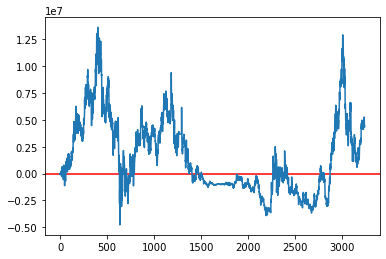

8 steps mean gain: 0.083
[2430, 809]


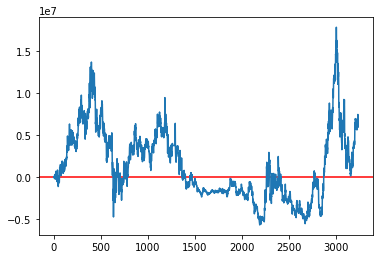

9 steps mean gain: 0.071
[2456, 783]


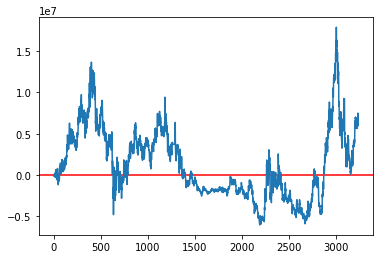

10 steps mean gain: 0.068
[2327, 912]


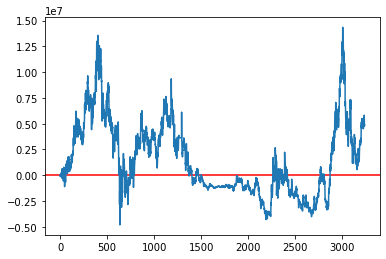

1 steps mean gain: 0.081
[2619, 620]


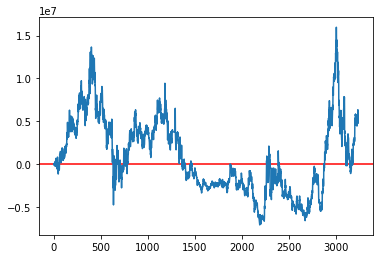

2 steps mean gain: 0.044
[2584, 655]


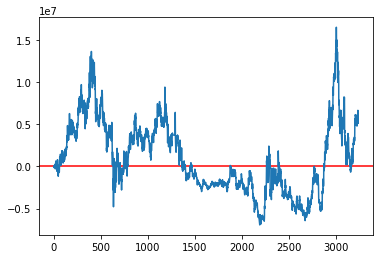

3 steps mean gain: 0.052
[2383, 856]


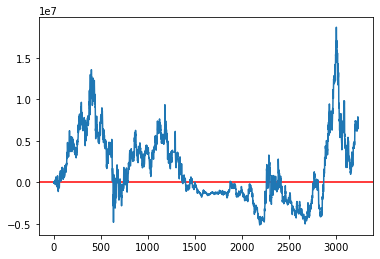

4 steps mean gain: 0.085
[2492, 747]


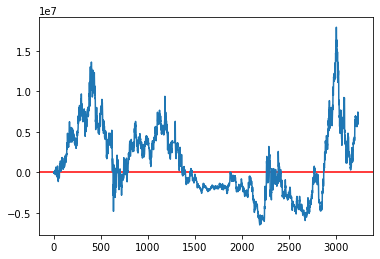

5 steps mean gain: 0.067
[2634, 605]


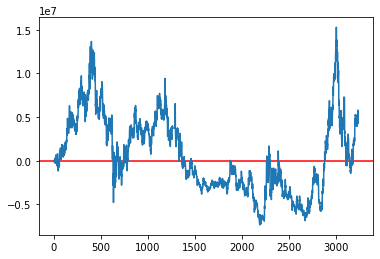

6 steps mean gain: 0.034
[2756, 483]


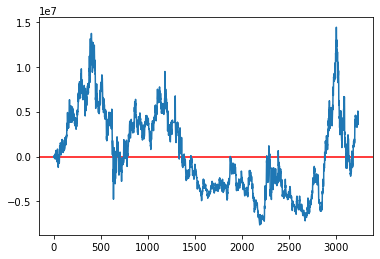

7 steps mean gain: 0.019
[2676, 563]


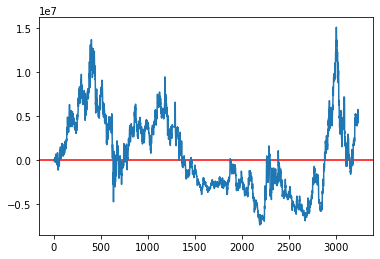

8 steps mean gain: 0.032
[2716, 523]


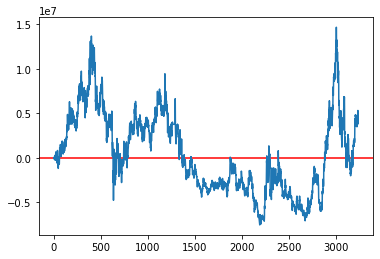

9 steps mean gain: 0.024
[2574, 665]


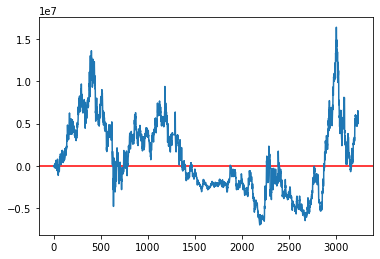

10 steps mean gain: 0.049
[2445, 794]


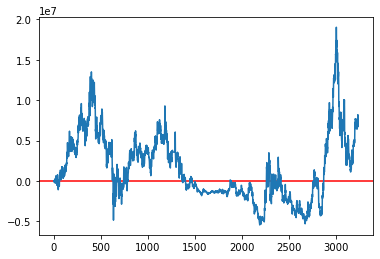

1 steps mean gain: 0.083
[2678, 561]


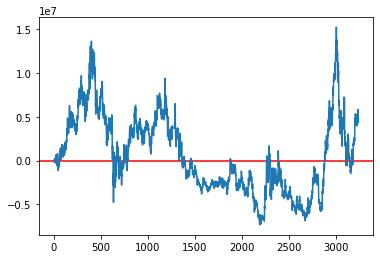

2 steps mean gain: 0.033
[2654, 585]


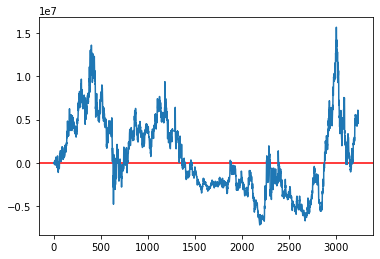

3 steps mean gain: 0.04
[2492, 747]


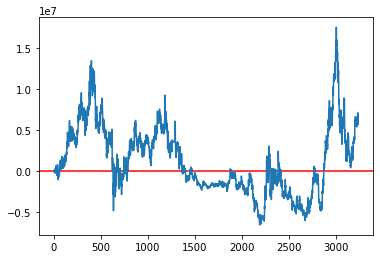

4 steps mean gain: 0.064
[2575, 664]


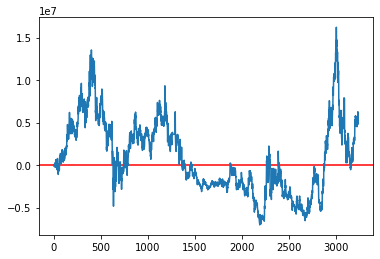

5 steps mean gain: 0.047
[2718, 521]


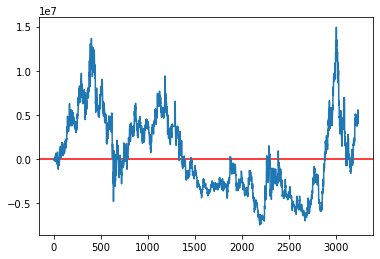

6 steps mean gain: 0.027
[2848, 391]


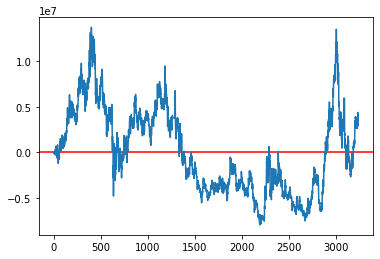

7 steps mean gain: 0.005
[2705, 534]


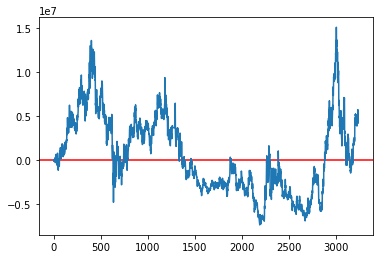

8 steps mean gain: 0.031
[2771, 468]


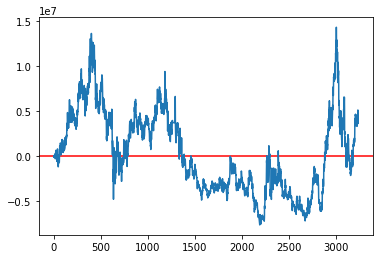

9 steps mean gain: 0.018
[2637, 602]


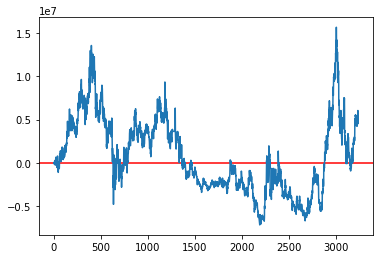

10 steps mean gain: 0.04
[2558, 681]


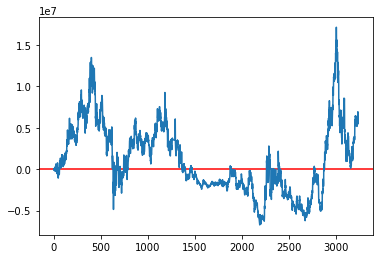

1 steps mean gain: 0.059
[2770, 469]


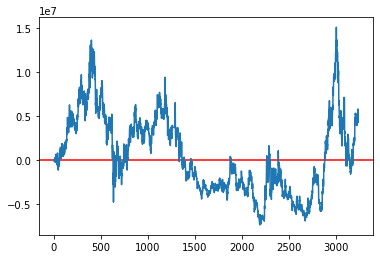

2 steps mean gain: 0.029
[2722, 517]


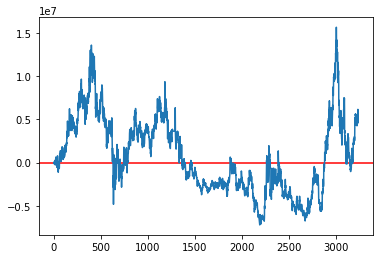

3 steps mean gain: 0.038
[2548, 691]


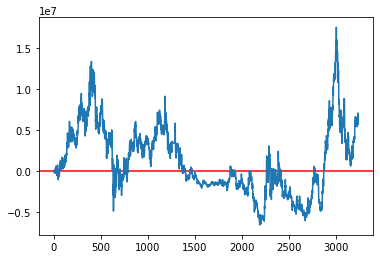

4 steps mean gain: 0.065
[2630, 609]


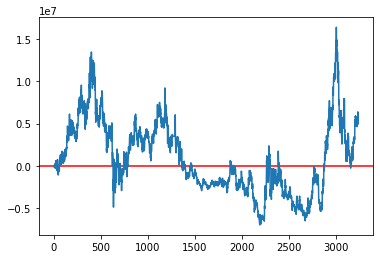

5 steps mean gain: 0.048
[2761, 478]


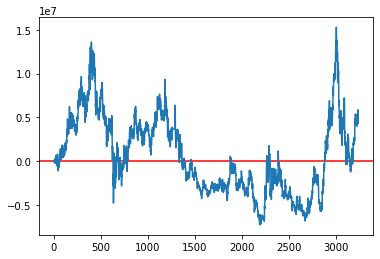

6 steps mean gain: 0.031
[2880, 359]


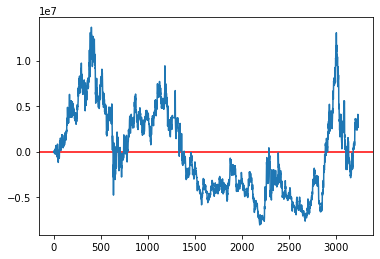

7 steps mean gain: -0.001
[2748, 491]


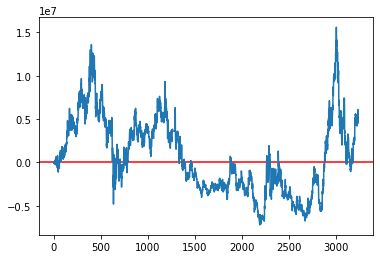

8 steps mean gain: 0.036
[2810, 429]


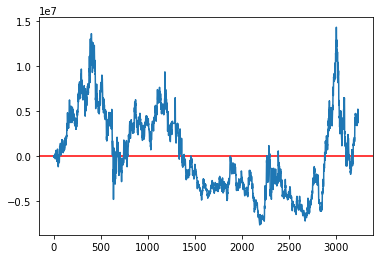

9 steps mean gain: 0.018
[2676, 563]


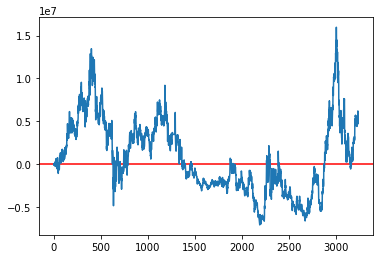

10 steps mean gain: 0.043
[2561, 678]


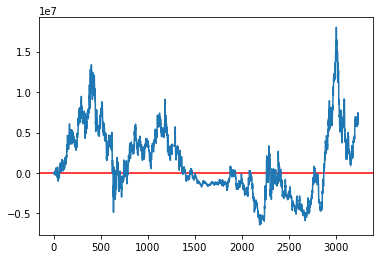

1 steps mean gain: 0.071
[2799, 440]


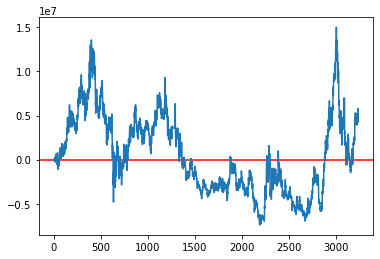

2 steps mean gain: 0.027
[2732, 507]


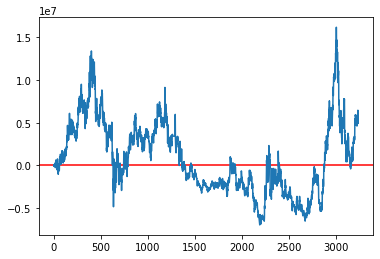

3 steps mean gain: 0.044
[2504, 735]


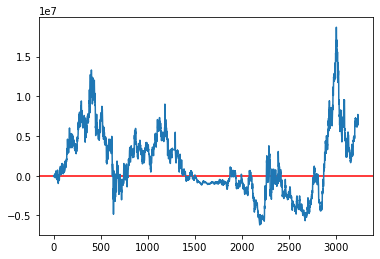

4 steps mean gain: 0.081
[2639, 600]


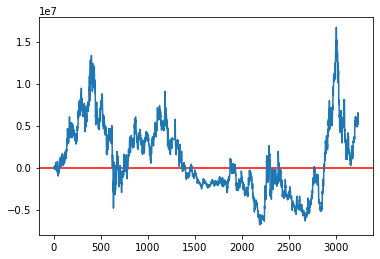

5 steps mean gain: 0.053
[2755, 484]


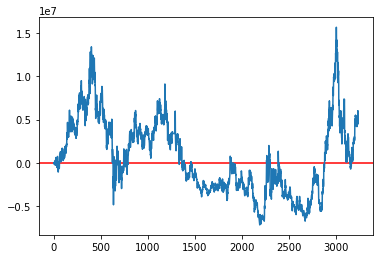

6 steps mean gain: 0.035
[2853, 386]


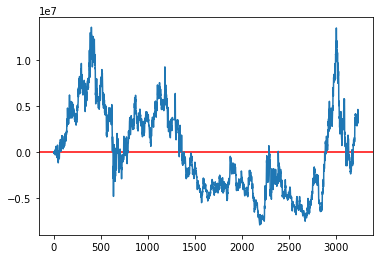

7 steps mean gain: 0.005
[2712, 527]


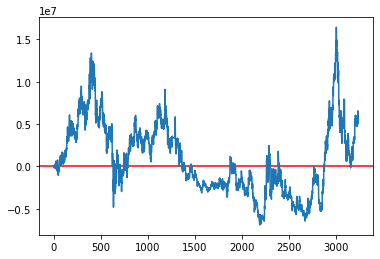

8 steps mean gain: 0.047
[2801, 438]


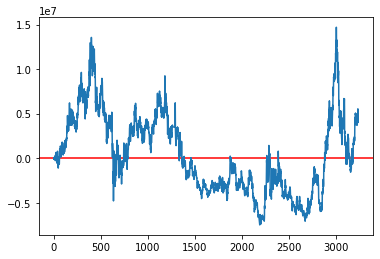

9 steps mean gain: 0.022
[2640, 599]


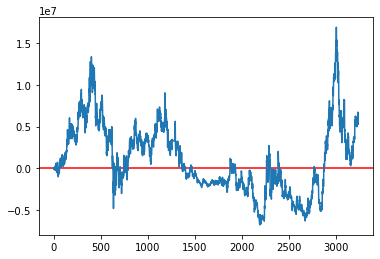

10 steps mean gain: 0.055
[2549, 690]


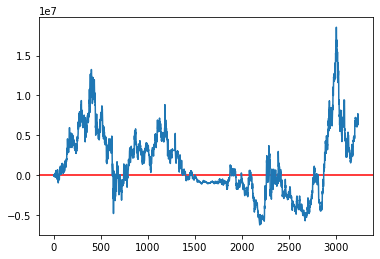

1 steps mean gain: 0.078
[2778, 461]


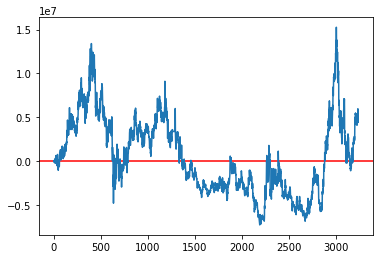

2 steps mean gain: 0.028
[2658, 581]


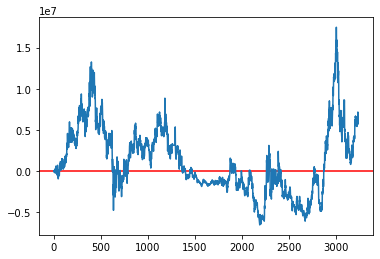

3 steps mean gain: 0.063
[2384, 855]


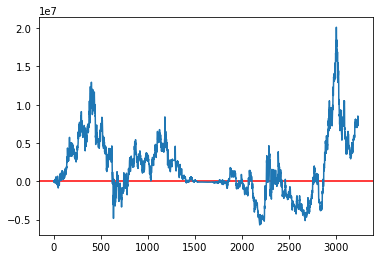

4 steps mean gain: 0.095
[2607, 632]


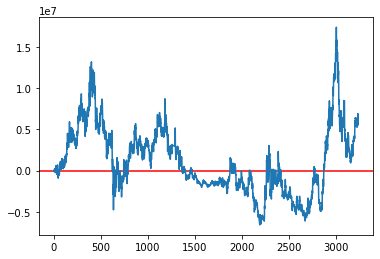

5 steps mean gain: 0.058
[2715, 524]


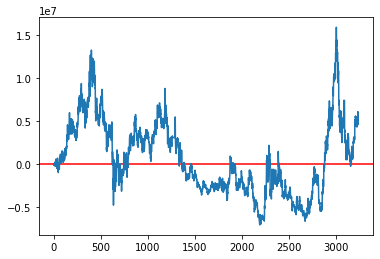

6 steps mean gain: 0.035
[2797, 442]


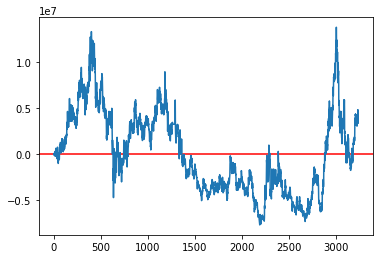

7 steps mean gain: 0.005
[2522, 717]


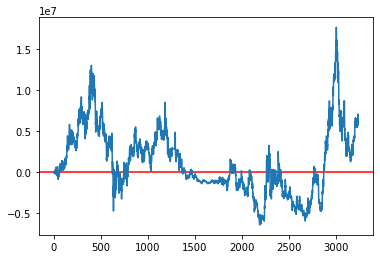

8 steps mean gain: 0.063
[2730, 509]


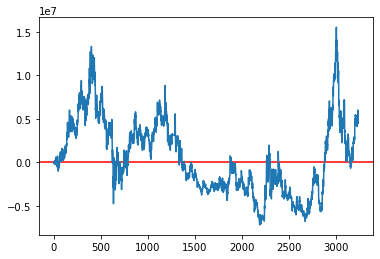

9 steps mean gain: 0.03
[2479, 760]


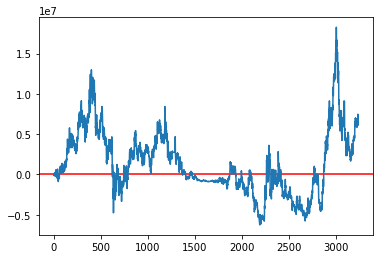

10 steps mean gain: 0.071
[2374, 865]


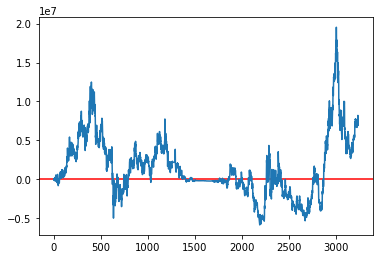

1 steps mean gain: 0.079
[2680, 559]


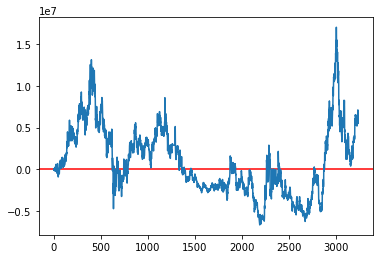

2 steps mean gain: 0.049
[2352, 887]


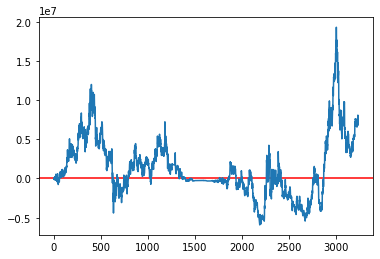

3 steps mean gain: 0.07
[2196, 1043]


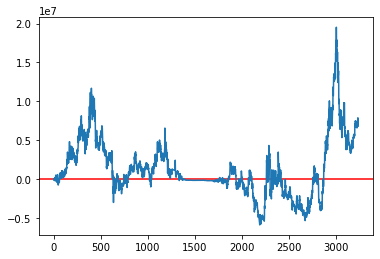

4 steps mean gain: 0.07
[2444, 795]


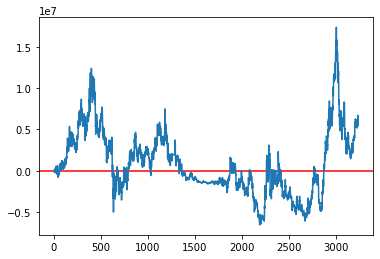

5 steps mean gain: 0.044
[2485, 754]


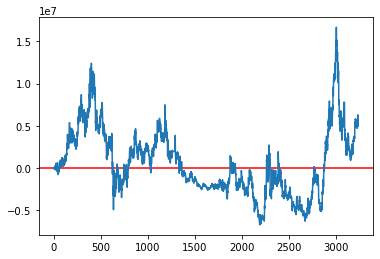

6 steps mean gain: 0.03
[2624, 615]


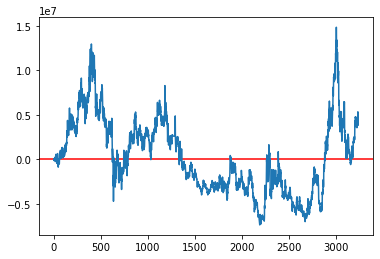

7 steps mean gain: 0.014
[2153, 1086]


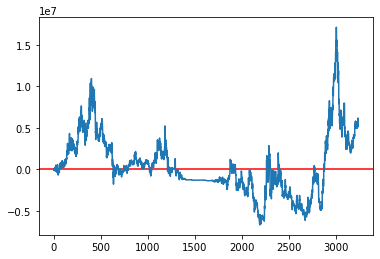

8 steps mean gain: 0.022
[2584, 655]


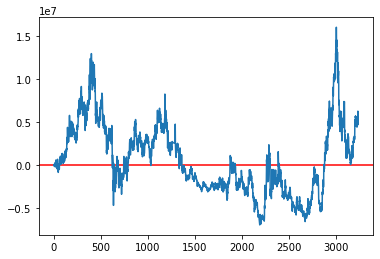

9 steps mean gain: 0.03
[2115, 1124]


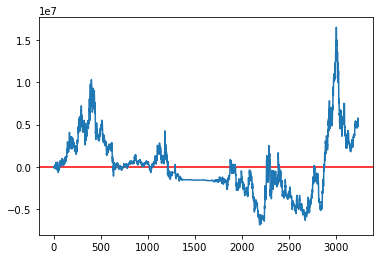

10 steps mean gain: 0.006
[1951, 1288]


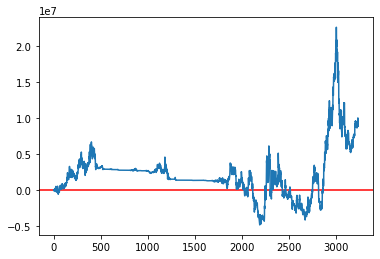

1 steps mean gain: 0.121
[2337, 902]


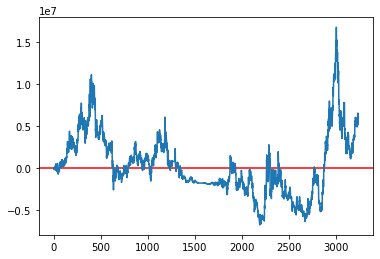

2 steps mean gain: 0.019
[1784, 1455]


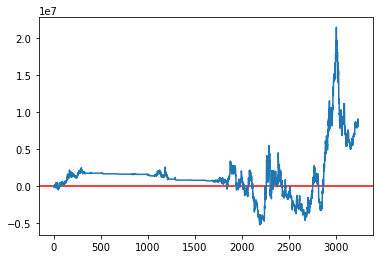

3 steps mean gain: 0.078
[1929, 1310]


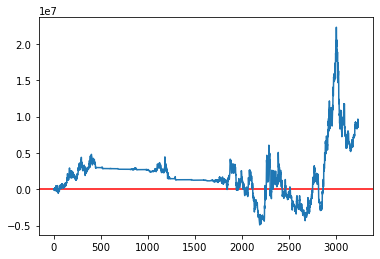

4 steps mean gain: 0.113
[1943, 1296]


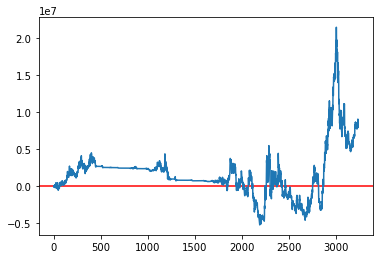

5 steps mean gain: 0.094
[2048, 1191]


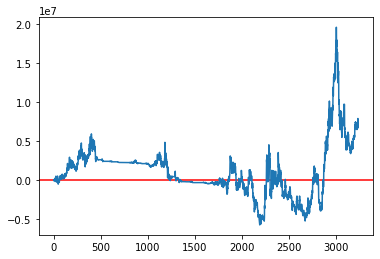

6 steps mean gain: 0.061
[2264, 975]


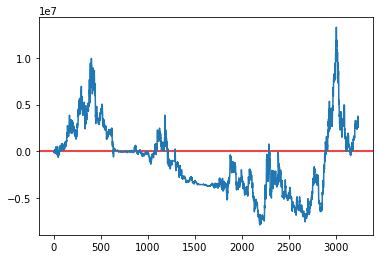

7 steps mean gain: -0.053
[1584, 1655]


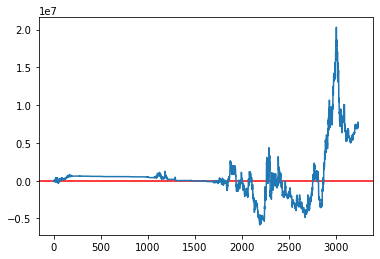

8 steps mean gain: 0.035
[2246, 993]


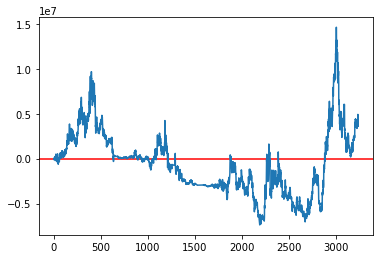

9 steps mean gain: -0.031
[1486, 1753]


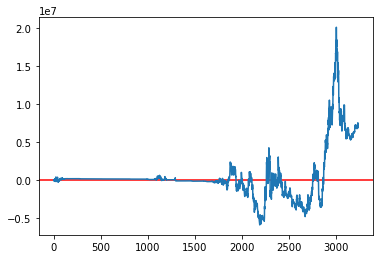

10 steps mean gain: 0.025
[1513, 1726]


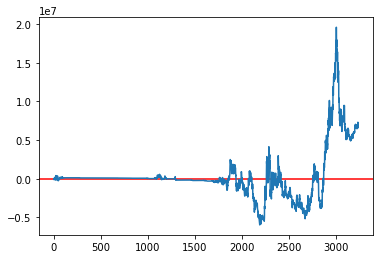

1 steps mean gain: 0.018
[1652, 1587]


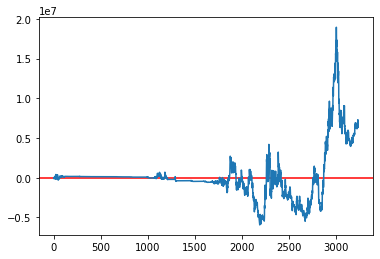

2 steps mean gain: 0.011
[1422, 1817]


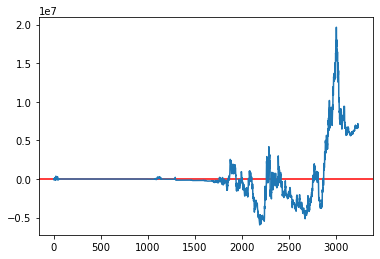

3 steps mean gain: 0.018
[1554, 1685]


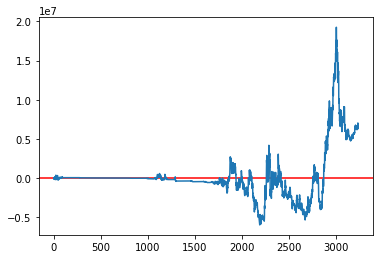

4 steps mean gain: 0.013
[1444, 1795]


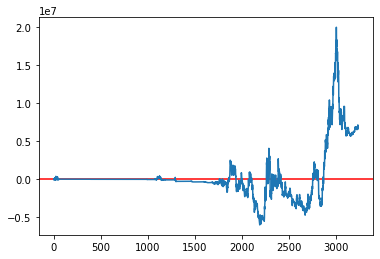

5 steps mean gain: 0.017
[1630, 1609]


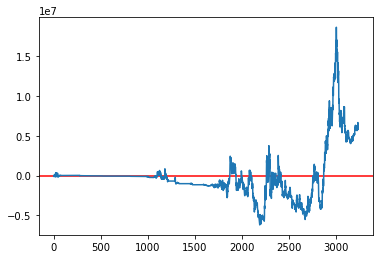

6 steps mean gain: -0.004
[1686, 1553]


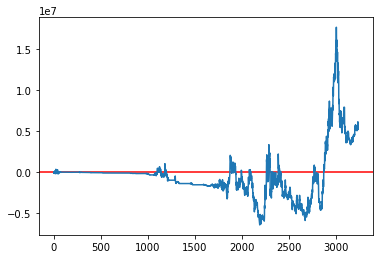

7 steps mean gain: -0.018
[1344, 1895]


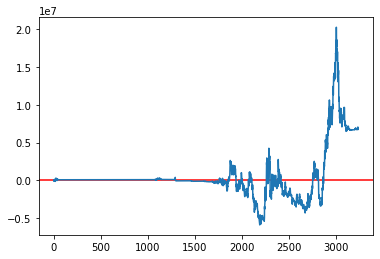

8 steps mean gain: 0.027
[1651, 1588]


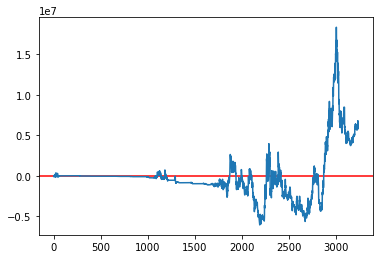

9 steps mean gain: -0.003
[1282, 1957]


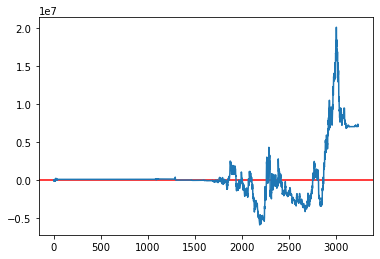

10 steps mean gain: 0.031
[1325, 1914]


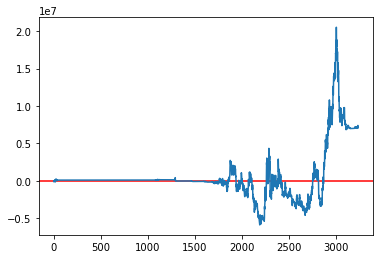

1 steps mean gain: 0.03
[1357, 1882]


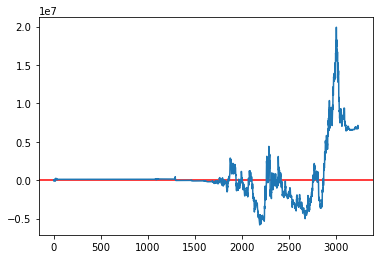

2 steps mean gain: 0.026
[1316, 1923]


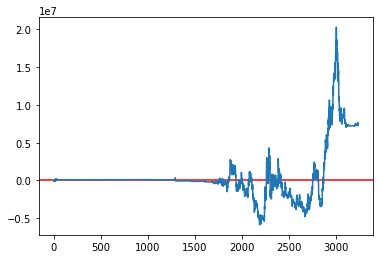

3 steps mean gain: 0.028
[1382, 1857]


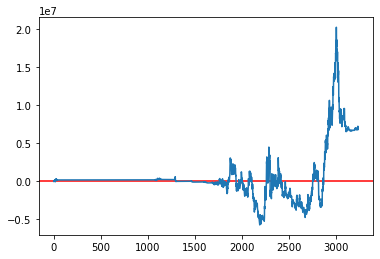

4 steps mean gain: 0.027
[1279, 1960]


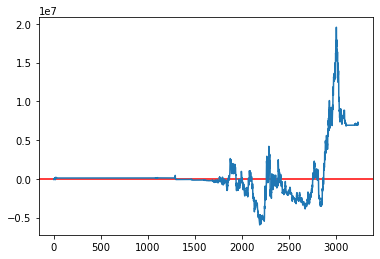

5 steps mean gain: 0.026
[1402, 1837]


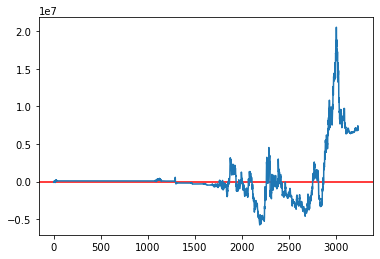

6 steps mean gain: 0.028
[1405, 1834]


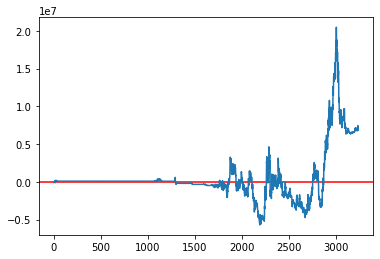

7 steps mean gain: 0.028
[1205, 2034]


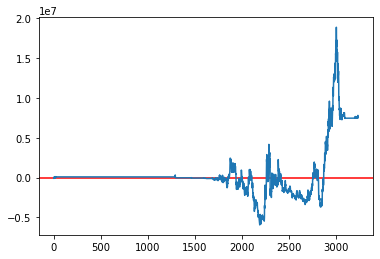

8 steps mean gain: 0.026
[1384, 1855]


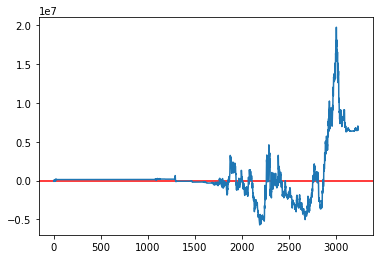

9 steps mean gain: 0.026
[1197, 2042]


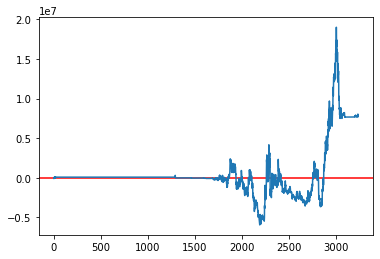

10 steps mean gain: 0.027
Wall time: 5min 52s


([1311.368314549327, 89.94965082910521], 28740224.808213662)

In [8]:
%%time
a.train(10)

In [9]:
gc.collect()

52755

In [10]:
np.mean(a.main.predict(state))

-0.464118

In [11]:
a.simulation(debug=True)

[0, 1] 18734470.0
[0, 2] 18621284.6714139
[0, 3] 18747690.74529028
[0, 4] 18721741.39100349
[0, 5] 18688763.654685974
[0, 6] 18673132.50595665
[0, 7] 18702713.56024921
[0, 8] 18723633.206105113
[0, 9] 18802463.37306285
[0, 10] 18771646.1583848
[0, 11] 18714010.1664958
[0, 12] 18746277.434818506
[0, 13] 18796248.864617825
[0, 14] 18796248.864617825
[0, 15] 18839103.58279264
[0, 16] 18721928.57933259
[0, 17] 18666150.647619963
[0, 18] 18727136.297281384
[0, 19] 18732369.92529118
[0, 20] 18783385.141856313
[0, 21] 18799985.821798682
[0, 22] 18799985.821798682
[0, 23] 18823710.648786306
[0, 24] 18798478.802951574
[0, 25] 18800008.5499537
[0, 26] 18800008.5499537
[0, 27] 18800008.5499537
[0, 28] 18800008.5499537
[0, 29] 18800008.5499537
[0, 30] 18800008.5499537
[0, 31] 18800008.5499537
[0, 32] 18800008.5499537
[0, 33] 18800008.5499537
[0, 34] 18800008.5499537
[0, 35] 18800008.5499537
[0, 36] 18800008.5499537
[0, 37] 18800008.5499537
[0, 38] 18800008.5499537
[0, 39] 18800008.5499537
[0, 40] 

[0, 444] 18800008.5499537
[0, 445] 18800008.5499537
[0, 446] 18800008.5499537
[0, 447] 18800008.5499537
[0, 448] 18800008.5499537
[0, 449] 18800008.5499537
[0, 450] 18800008.5499537
[0, 451] 18800008.5499537
[0, 452] 18800008.5499537
[0, 453] 18800008.5499537
[0, 454] 18800008.5499537
[0, 455] 18800008.5499537
[0, 456] 18800008.5499537
[0, 457] 18800008.5499537
[0, 458] 18800008.5499537
[0, 459] 18800008.5499537
[0, 460] 18800008.5499537
[0, 461] 18800008.5499537
[0, 462] 18800008.5499537
[0, 463] 18800008.5499537
[0, 464] 18800008.5499537
[0, 465] 18800008.5499537
[0, 466] 18800008.5499537
[0, 467] 18800008.5499537
[0, 468] 18800008.5499537
[0, 469] 18800008.5499537
[0, 470] 18800008.5499537
[0, 471] 18800008.5499537
[0, 472] 18800008.5499537
[0, 473] 18800008.5499537
[0, 474] 18800008.5499537
[0, 475] 18800008.5499537
[0, 476] 18800008.5499537
[0, 477] 18800008.5499537
[0, 478] 18800008.5499537
[0, 479] 18800008.5499537
[0, 480] 18800008.5499537
[0, 481] 18800008.5499537
[0, 482] 188

[0, 888] 18800008.5499537
[0, 889] 18800008.5499537
[0, 890] 18800008.5499537
[0, 891] 18800008.5499537
[0, 892] 18800008.5499537
[0, 893] 18800008.5499537
[0, 894] 18800008.5499537
[0, 895] 18800008.5499537
[0, 896] 18800008.5499537
[0, 897] 18800008.5499537
[0, 898] 18800008.5499537
[0, 899] 18800008.5499537
[0, 900] 18800008.5499537
[0, 901] 18800008.5499537
[0, 902] 18800008.5499537
[0, 903] 18800008.5499537
[0, 904] 18800008.5499537
[0, 905] 18800008.5499537
[0, 906] 18800008.5499537
[0, 907] 18800008.5499537
[0, 908] 18800008.5499537
[0, 909] 18800008.5499537
[0, 910] 18800008.5499537
[0, 911] 18800008.5499537
[0, 912] 18800008.5499537
[0, 913] 18800008.5499537
[0, 914] 18800008.5499537
[0, 915] 18800008.5499537
[0, 916] 18800008.5499537
[0, 917] 18800008.5499537
[0, 918] 18800008.5499537
[0, 919] 18800008.5499537
[0, 920] 18800008.5499537
[0, 921] 18800008.5499537
[0, 922] 18800008.5499537
[0, 923] 18800008.5499537
[0, 924] 18800008.5499537
[0, 925] 18800008.5499537
[0, 926] 188

[6, 1201] 18799428.59136711
[6, 1202] 18799428.59136711
[6, 1203] 18799428.59136711
[6, 1204] 18799428.59136711
[6, 1205] 18799428.59136711
[6, 1206] 18799428.59136711
[6, 1207] 18799428.59136711
[6, 1208] 18799428.59136711
[6, 1209] 18799428.59136711
[6, 1210] 18799428.59136711
[6, 1211] 18799428.59136711
[6, 1212] 18799428.59136711
[6, 1213] 18799428.59136711
[6, 1214] 18799428.59136711
[6, 1215] 18799428.59136711
[6, 1216] 18799428.59136711
[6, 1217] 18799428.59136711
[6, 1218] 18799428.59136711
[6, 1219] 18799428.59136711
[6, 1220] 18799428.59136711
[6, 1221] 18799428.59136711
[6, 1222] 18799428.59136711
[6, 1223] 18799428.59136711
[6, 1224] 18799428.59136711
[6, 1225] 18799428.59136711
[6, 1226] 18799428.59136711
[6, 1227] 18799428.59136711
[6, 1228] 18799428.59136711
[6, 1229] 18799428.59136711
[6, 1230] 18799428.59136711
[6, 1231] 18799428.59136711
[6, 1232] 18799428.59136711
[6, 1233] 18799428.59136711
[6, 1234] 18799428.59136711
[6, 1235] 18799428.59136711
[6, 1236] 18799428.5

[47, 1447] 18675627.26970415
[47, 1448] 18675627.26970415
[47, 1449] 18675627.26970415
[47, 1450] 18675627.26970415
[47, 1451] 18675627.26970415
[47, 1452] 18675627.26970415
[47, 1453] 18675627.26970415
[47, 1454] 18675627.26970415
[47, 1455] 18675627.26970415
[47, 1456] 18675627.26970415
[47, 1457] 18675627.26970415
[47, 1458] 18675627.26970415
[47, 1459] 18675627.26970415
[47, 1460] 18675627.26970415
[47, 1461] 18675627.26970415
[47, 1462] 18675627.26970415
[47, 1463] 18675627.26970415
[47, 1464] 18675627.26970415
[47, 1465] 18675627.26970415
[47, 1466] 18675627.26970415
[47, 1467] 18675627.26970415
[47, 1468] 18675627.26970415
[47, 1469] 18675627.26970415
[47, 1470] 18675627.26970415
[47, 1471] 18675627.26970415
[47, 1472] 18675627.26970415
[47, 1473] 18675627.26970415
[47, 1474] 18675627.26970415
[47, 1475] 18675627.26970415
[47, 1476] 18675627.26970415
[47, 1477] 18675627.26970415
[47, 1478] 18675627.26970415
[47, 1479] 18675627.26970415
[47, 1480] 18675627.26970415
[47, 1481] 186

[193, 1587] 18589520.25231372
[194, 1587] 18540855.868917212
[195, 1587] 18508187.585022554
[196, 1587] 18491746.618654832
[197, 1587] 18392514.0436406
[198, 1587] 18392514.0436406
[199, 1587] 18476079.86450593
[200, 1587] 18492902.53832589
[201, 1587] 18391340.6749333
[202, 1587] 18255185.464199886
[203, 1587] 18392134.76025711
[204, 1587] 18254477.553304538
[205, 1587] 18530650.74211012
[206, 1587] 18461319.538112983
[207, 1587] 18600701.95096384
[208, 1587] 18688320.956927046
[209, 1587] 19023837.861176834
[210, 1587] 18845351.501908407
[211, 1587] 18575849.909875795
[211, 1588] 18431480.3060631
[211, 1589] 18161011.219781145
[211, 1590] 18232812.092881903
[211, 1591] 18143327.391352758
[211, 1592] 18143327.391352758
[211, 1593] 18178928.228494033
[212, 1593] 18339087.498922154
[213, 1593] 18339087.498922154
[213, 1594] 18196417.60446529
[214, 1594] 18339040.97511272
[215, 1594] 18428405.80268602
[216, 1594] 18697662.93070118
[217, 1594] 18625402.346913025
[218, 1594] 18788996.18243

[462, 1624] 18880508.237114653
[463, 1624] 18880508.237114653
[464, 1624] 19360521.158397228
[465, 1624] 19720530.849359162
[466, 1624] 19600527.619038515
[467, 1624] 19040512.544208843
[468, 1624] 18680502.853246912
[469, 1624] 18720503.93002046
[470, 1624] 18680502.853246912
[471, 1624] 19520525.46549142
[472, 1624] 18960510.39066175
[473, 1624] 18840507.160341106
[474, 1624] 18680502.853246912
[475, 1624] 18360494.239058528
[476, 1624] 18800506.083567556
[477, 1624] 18800506.083567556
[478, 1624] 18640501.776473366
[479, 1624] 18560499.62292627
[480, 1624] 18920509.3138882
[481, 1624] 18960510.39066175
[482, 1624] 18840507.160341106
[483, 1624] 18680502.853246912
[484, 1624] 18600500.699699815
[485, 1624] 18400495.31583208
[486, 1624] 17640474.857134666
[487, 1624] 17400468.396493375
[488, 1624] 17920482.3945495
[489, 1624] 17720477.01068176
[490, 1624] 17640474.857134666
[491, 1624] 17440469.473266926
[492, 1624] 18040485.624870144
[492, 1625] 17360467.31971983
[492, 1626] 16720798

[694, 1707] 19522111.125302397
[694, 1708] 19494919.023510613
[694, 1709] 18951694.458863217
[694, 1710] 18843450.94948007
[694, 1711] 18574018.229382314
[694, 1712] 18520385.61956734
[694, 1713] 18840706.044455305
[694, 1714] 18840706.044455305
[694, 1715] 18177975.33722002
[694, 1716] 18625900.253402837
[694, 1717] 18599657.723034285
[694, 1718] 18756525.481533583
[694, 1719] 18730438.65679581
[695, 1719] 19225153.930293243
[695, 1720] 18990740.49378847
[695, 1721] 18912701.985782176
[695, 1722] 18990702.262542296
[696, 1722] 18756837.653275903
[697, 1722] 18496788.019889314
[698, 1722] 18496788.019889314
[699, 1722] 18130917.813059904
[700, 1722] 17764933.78139358
[701, 1722] 18000229.929197118
[702, 1722] 18235867.35473783
[702, 1723] 17816469.989699658
[703, 1723] 17737884.89523945
[704, 1723] 18078695.20004133
[705, 1723] 18078695.20004133
[706, 1723] 18078695.20004133
[707, 1723] 18316401.672060758
[708, 1723] 17680576.914537556
[708, 1724] 17786603.707124542
[708, 1725] 1691424

[841, 1833] 15300266.72808179
[841, 1834] 15151494.761004321
[842, 1834] 15225864.942018073
[843, 1834] 15473886.532209057
[844, 1834] 15548453.11825732
[845, 1834] 15523538.32087647
[846, 1834] 15698408.520469379
[847, 1834] 15573208.542861424
[848, 1834] 15748819.935126735
[849, 1834] 15748819.935126735
[850, 1834] 15799317.747539982
[851, 1834] 15546113.517429775
[852, 1834] 15622305.742808634
[853, 1834] 15596828.217749216
[854, 1834] 15443602.226282362
[855, 1834] 15418022.427982258
[856, 1834] 15418022.427982258
[857, 1834] 15546528.441324925
[858, 1834] 15752946.334438903
[859, 1834] 15623357.960202748
[860, 1834] 15597331.736274727
[861, 1834] 15649614.138909915
[862, 1834] 15886053.923171075
[863, 1834] 16018169.329268478
[864, 1834] 16257372.714177087
[865, 1834] 16096954.340054194
[866, 1834] 16016349.4584985
[867, 1834] 16043356.029255219
[868, 1834] 16260710.51166983
[869, 1834] 16506762.689578421
[870, 1834] 16726981.46509148
[871, 1834] 17087296.487533934
[872, 1834] 167

[1130, 1923] 27258254.59069196
[1130, 1924] 27545648.769338176
[1130, 1925] 27378372.193929356
[1130, 1926] 27459454.637565237
[1130, 1927] 27314907.034717448
[1130, 1928] 27023966.512187753
[1130, 1929] 26999675.645203087
[1130, 1930] 26723431.190655436
[1130, 1931] 26625376.639767464
[1130, 1932] 26493044.84380748
[1130, 1933] 26407392.315638892
[1130, 1934] 26380886.697880644
[1130, 1935] 26463211.513937436
[1130, 1936] 26220667.625626996
[1130, 1937] 26248321.899164274
[1130, 1938] 26393542.375114135
[1130, 1939] 26585775.905622333
[1130, 1940] 26618401.43638304
[1130, 1941] 26583096.6004197
[1130, 1942] 26644517.783081263
[1130, 1943] 26758966.795657434
[1130, 1944] 26657980.362941295
[1130, 1945] 26709720.792938057
[1130, 1946] 26694443.734667007
[1130, 1947] 26723531.815843053
[1130, 1948] 26681484.120005194
[1130, 1949] 26684830.556572173
[1130, 1950] 26636319.535369813
[1130, 1951] 26615037.878080755
[1130, 1952] 26623685.33313042
[1131, 1952] 26673568.484397057
[1132, 1952] 2

[18734470.0,
 18621284.6714139,
 18747690.74529028,
 18721741.39100349,
 18688763.654685974,
 18673132.50595665,
 18702713.56024921,
 18723633.206105113,
 18802463.37306285,
 18771646.1583848,
 18714010.1664958,
 18746277.434818506,
 18796248.864617825,
 18796248.864617825,
 18839103.58279264,
 18721928.57933259,
 18666150.647619963,
 18727136.297281384,
 18732369.92529118,
 18783385.141856313,
 18799985.821798682,
 18799985.821798682,
 18823710.648786306,
 18798478.802951574,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 18800008.5499537,
 1880